In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from math import sin, cos

In [67]:
df = pd.read_csv('interpolated.csv')

# Dataset preparation for Hybrid Approach

In hybrid approach, data only come from center camera. 

In this data frame, from top to bottom, time increase.

In [70]:
center_cam_idx = df['frame_id'] == 'center_camera'
center_cam_df = df[center_cam_idx]

# Transform Regression to Classification

To increase the reliability of Network output, the of the network is trained to output the class of steering angle instead of value of steering angle. Therefore, steering angles are divided into classes based on the histogram of the raw dataset.

Each bin of the histogram has the width of `0.01 rad` which is the jigling of humans when driving on straight road.   

Note:
Diffrenet dataset, take the global max & global min of steering angles, calculate list of bin edges, input this list to plt.hist()

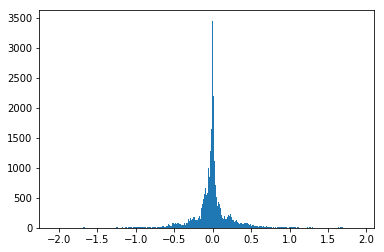

In [71]:
# Histogram of raw dataset
BIN_WIDTH = 0.01  # rad
num_bins = int((max(center_cam_df.angle) - min(center_cam_df.angle)) / BIN_WIDTH) + 1
steering_bin_cnt, steering_bin_edges, _ = plt.hist(center_cam_df.angle, bins=num_bins)

Text(0, 0.5, 'bin width (rad)')

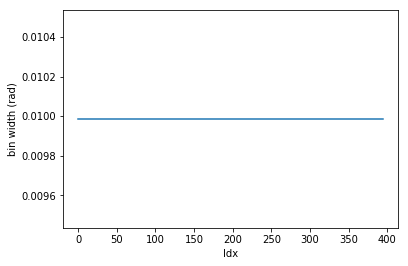

In [72]:
# Test bins width
bins_width = [np.round(steering_bin_edges[i + 1] - steering_bin_edges[i], decimals=6) for i in range(num_bins - 1)]
plt.plot(bins_width)
plt.xlabel('Idx')
plt.ylabel('bin width (rad)')

In [73]:
# Append 'steering_id' column to dataframe
center_cam_df['steering_id'] = pd.Series(np.array([-1 for i in range(len(center_cam_df.index))]), 
                                         index=center_cam_df.index)

# Iterate through center_cam_df aside class to each row
def findSteeringId(idx, center_cam_df, steering_bin_edges):
    """
    Find id for idx-th row of center_cam_df w.r.t this row's steering angle
    
    Input:
        idx: row index of center_cam_df (scalar)
        center_cam_df: dataframe  (pd.Dataframe)
        steering_bin_edges: array of bin edges (np.array)
    
    Output:
        assign steering class to inputted row
    """
    steering_angle = center_cam_df.iloc[idx].angle
    i = 0
    flag_found_bin = False
    while i < (num_bins - 1) and not flag_found_bin:
        if steering_angle >= steering_bin_edges[i] and steering_angle < steering_bin_edges[i + 1]:
            flag_found_bin = True
            center_cam_df.steering_id.iat[idx] = i  # use iat[] to make sure the change is made to center_cam_df 
            # itself, not a copy of center_cam_df
        i += 1
    
    if not flag_found_bin:
        # not found any bin contains this steering angle --> equal to the right edge of the last bin
        center_cam_df.iloc[idx].steering_id = i

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
# Test with 1 cell
idx = 10
findSteeringId(idx, center_cam_df, steering_bin_edges)
center_cam_df.iloc[idx]

index           2016-11-17 23:10:16.380799785
timestamp                 1479424216380799785
width                                     640
height                                    480
frame_id                        center_camera
filename       center/1479424216380799785.png
angle                               0.0279253
torque                               0.221489
speed                                  23.052
lat                                   37.5452
long                                 -122.327
alt                                   8.79524
steering_id                               208
Name: 32, dtype: object

In [75]:
# Assign steering_id to every column of center_cam_df
for i in range(len(center_cam_df)):
    findSteeringId(i, center_cam_df, steering_bin_edges)


/home/user/.local/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


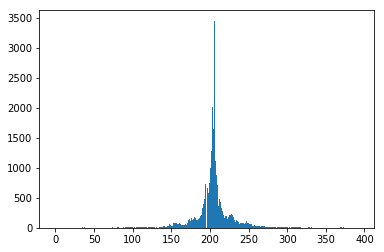

In [76]:
# Check steering_id
_, _, _ = plt.hist(center_cam_df.steering_id, bins=num_bins)

Note:
Steering_id has the same distribution as steering angle.

## Calculate distance between 2 adjacent frames

In [77]:
def latLong2XYZ(lat, long):
    """
    Convert latitude & longitude into Earth-centered earth-fixed Cartesian coordinate
    z goes through 2 poles
    x cuts 0-latitude line & 0-longitude line
    y = z cross x
    
    Input:
        lat: latitude (scalar)
        long: longitude (scalar)
    
    Output:
        (x, y, z): Cartesian coordinate (list)
    """
    R = 6.3781 * 1e6  # earth radius (meter)
    z = R * sin(lat)
    x = R * cos(lat) * cos(long)
    y = R * cos(lat) * sin(long)
    
    return [x, y, z]


def _distance(p1, p2):
    """
    Calculate distance between 2 points in Cartesian space
    
    Input:
        p1 & p2: Cartesian coordiante (list)
    
    Return:
        distance between p1 & p2 (scalar)
    """
    p1 = np.array(p1)
    p2 = np.array(p2)
    return np.linalg.norm(p1 - p2)
    
    
def f2fDistance(df1, df2, display=False):
    """
    Calculate distance travelled between 2 data frame
    
    Input:
        df1 & df2: pandas.core.series.Series
    
    Output:
        distancetravelled between df1 & df2 (scalar)
    """
    p1 = latLong2XYZ(df1.lat * np.pi/180, df1.long * np.pi/180)
    p2 = latLong2XYZ(df2.lat * np.pi/180, df2.long * np.pi/180)
    
    if display:
        print('p1:\t', p1)
        print('p2:\t', p2)
        
    return _distance(p1, p2)

In [78]:
inter_frame_dist = np.array([f2fDistance(center_cam_df.iloc[i], center_cam_df.iloc[i + 1]) for i in range(len(center_cam_df) - 1)])

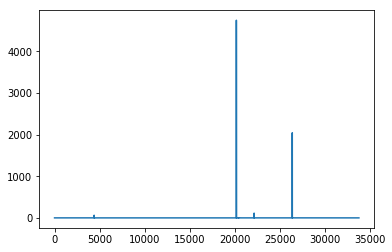

In [79]:
plt.plot(inter_frame_dist)
plt.show()

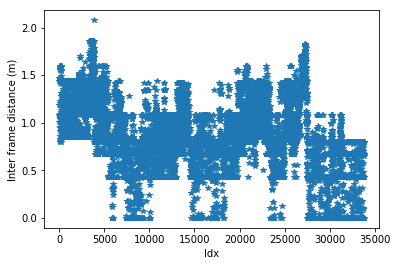

In [80]:
def filterOutlierDistance(inter_frame_dist, bins_edge_arr=[0, 10, 10000]):
    """
    Remove outlier w.r.t distance between 2 adjacent frames
    Input:
        inter_frame_dist: array of distance between 2 adjacent frames (np.array)
    Output:
        filtered_inter_frame_dist (np.array)
        filtered_idx: T/F array of index of inter_frame_dist, False for outlier distance (np.array)
    """
    bins_cnt, bins_edge = np.histogram(inter_frame_dist, bins=bins_edge_arr)
    filtered_idx = inter_frame_dist < bins_edge_arr[1]
    return inter_frame_dist[filtered_idx], filtered_idx
    
filtered_inter_frame_dist, filtered_idx = filterOutlierDistance(inter_frame_dist)
plt.plot(filtered_inter_frame_dist, '*')
plt.xlabel('Idx')
plt.ylabel('Inter frame distance (m)')
plt.show()

## Create Dataset

Each sample in the dataset is a chunk of images (number of images can varies) with the total travelled distance is at least 37 meters
* 12 meters of Spatial History
* 25 meters of Planning Horizon

In [81]:
SPATIAL_HISTORY = 12.
PLANNING_HORIZON = 25.

In [82]:
def generateTrainingSample(center_cam_df, inter_frame_dist, filtered_idx, starting_idx):
    """
    Generate 1 training sample as a dictionary with 3 items: frames_list, steering_angles_list, steering_ids_list, 
    and travelled_dist_list
    
    Input:
        center_cam_df: dataframe contains info frame captured by center camera only (pandas.Dataframe)
        inter_frame_dist: raw array of distance between 2 adjacent frames (np.array)
        filtered_idx: T/F array of index of inter_frame_dist, False for outlier distance (np.array)
        starting_idx: idx of frame starting from which the training sample is built
    
    Output:
        if sample is complete (contains 35 meteres)
            training_sample: (python dict)  
        else
            idx in center_cam_df of last element of sample 
        
    """
    if starting_idx > len(inter_frame_dist) - 1:
        return starting_idx
    
    # initilize
    frames_list = [center_cam_df.iloc[starting_idx].filename]
    steering_angles_list = [center_cam_df.iloc[starting_idx].angle]
    steering_ids_list = [center_cam_df.iloc[starting_idx].steering_id]
    travelled_dist_list = [0.]
    total_dist = 0.
    i = starting_idx + 1  # idx of row in center_cam_df 
    # loop
    incomplete_sample = False
    start_print = False
    while total_dist < (SPATIAL_HISTORY + PLANNING_HORIZON):
        if i - 1 == len(inter_frame_dist) - 1:
            print('End of inter_frame_dist')
            incomplete_sample = True
            break
            
        if filtered_idx[i - 1]:
            total_dist += inter_frame_dist[i - 1]
            frames_list.append(center_cam_df.iloc[i].filename)
            steering_angles_list.append(center_cam_df.iloc[i].angle)
            steering_ids_list.append(center_cam_df.iloc[i].steering_id)
            travelled_dist_list.append(total_dist)
            i += 1
        else:
            print('Early stopping due to end of segment')
            incomplete_sample = True
            break
    
    if incomplete_sample:
        return i
            
    return {'frames': frames_list, 
            'steering_angles': steering_angles_list,
            'steering_ids': steering_ids_list, 
            'travelled_dist': travelled_dist_list}

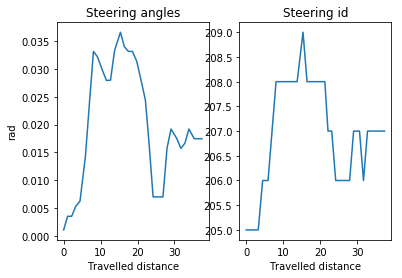

In [84]:
training_sample = generateTrainingSample(center_cam_df, inter_frame_dist, filtered_idx, 0)

plt.subplot(121)
plt.plot(training_sample['travelled_dist'], training_sample['steering_angles'])
plt.title('Steering angles')
plt.xlabel('Travelled distance')
plt.ylabel('rad')
plt.subplot(122)
plt.plot(training_sample['travelled_dist'], training_sample['steering_ids'])
plt.title('Steering id')
plt.xlabel('Travelled distance')

plt.show()

In [85]:
# Generate dataset
hybrid_dataset = []  # list of dictionary

starting_idx = 0 
while starting_idx < len(center_cam_idx):
    out = generateTrainingSample(center_cam_df, inter_frame_dist, filtered_idx, starting_idx)
    if type(out) == dict:  # get a complete sample
        hybrid_dataset.append(out)
        starting_idx += len(out['travelled_dist'])
    else:
        starting_idx = out + 1 # 
    

Early stopping due to end of segment
Early stopping due to end of segment
Early stopping due to end of segment
Early stopping due to end of segment
End of inter_frame_dist


### Checkout dataset 

In [86]:
len(hybrid_dataset)

723

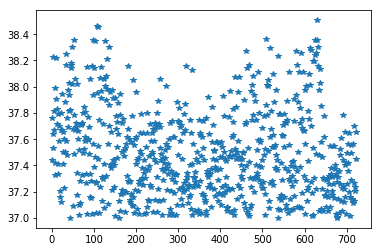

In [87]:
# Test the travelled distance among the hybrid_dataset
travelled_distance_list = [sample['travelled_dist'][-1] for sample in hybrid_dataset]

plt.plot(travelled_distance_list, '*')
plt.show()

## Filter hybrid dataset 
This step is to make training sample from the `hybrid_dataset` generated above. Each training sample contained a feature list `X` and label `y`. 

The feature list `X` is made of by 3 images with distance between 2 adjacent image is 4 meters. `X` plays the role of Spatial History

The label `y` is a vector of `N` number represents steering angles applied to the `PLANNING_HORIZON` with `D` meters between two different steering angles.

In [88]:
D = 1
N = int(PLANNING_HORIZON / D)
SPATIAL_HISTORY_INTER_FRAME_DIST = 4
SPATIAL_HISTORY_LEN = int(SPATIAL_HISTORY / SPATIAL_HISTORY_INTER_FRAME_DIST)

In [89]:
def convertToTrainingSample(sample):
    """
    Convert a sample hybrid_dataset to training sample
    
    Input:
        sample: a sample of hybrid_dataset (python dict)
    
    Output:
        training_sample: {'X': list of images, 'y': list of steering ids applied to PLANNING_HORIZON,
                        'steering_angles': list of steering angles associate with 'y' (for debugging)
                        'travelled_dist': list of associate travelled distance (for debugging)}  
    """
    
    # Construct X (the spatial history)
    X = [sample['frames'][0]]  # initialize
    _dist = [sample['travelled_dist'][0]]
    i = 1
    while len(X) < SPATIAL_HISTORY_LEN:
        if sample['travelled_dist'][i] > 0.875 * SPATIAL_HISTORY_INTER_FRAME_DIST * len(X):
            X.append(sample['frames'][i])
            _dist.append(sample['travelled_dist'][i])
        i += 1
    
    # Construct y
    y = [sample['steering_ids'][i - 1]]  # last element of X (i.e. now) is first element of y
    steering_angles_list = [sample['steering_angles'][i - 1]]
    y_is_completed = False
    while i < len(sample['steering_angles']):
        if sample['travelled_dist'][i] > 0.875 * D * len(y):
            y.append(sample['steering_ids'][i])
            steering_angles_list.append(sample['steering_angles'][i])
            _dist.append(sample['travelled_dist'][i])
        
        i += 1
        
        if len(y) == N:
            y_is_completed = True
            break
    
    if not y_is_completed:
        print('not enough labels (len(y) = %d) --> pad y with its last value' % len(y))
        pad_value = y[-1]
        pad_steering = steering_angles_list[-1]
        while len(y) < N:
            y.append(pad_value)
            steering_angles_list.append(pad_steering)
        
    
    
    return {'X': X, 'y': y, 
            'steering_angles': steering_angles_list, 'travelled_dist': _dist}
    
    

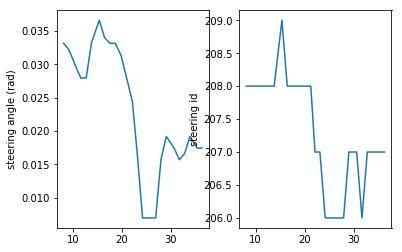

In [92]:
training_sample = convertToTrainingSample(hybrid_dataset[0])

plt.subplot(121)
plt.plot(training_sample['travelled_dist'][2:], training_sample['steering_angles'])
plt.ylabel('steering angle (rad)')
plt.subplot(122)
plt.plot(training_sample['travelled_dist'][2:], training_sample['y'])
plt.ylabel('steering id')
plt.show()

In [94]:
# create training dataset
training_dataset = [convertToTrainingSample(sample) for sample in hybrid_dataset]  # list of dictionary

not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 23) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enough labels (len(y) = 24) --> pad y with its last value
not enou

In [95]:
len(training_dataset)

723